In [12]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
import seaborn as sns
from windrose import WindroseAxes

In [2]:
pph = xr.open_dataset('data/pph/labelled_pph.nc')
all_pph_dates = pph['time']
pph_dates = all_pph_dates[all_pph_dates <= '202312310000']
pph_dates = pph_dates[pph_dates >= '198701160000']
pph = pph.sel(time = pph_dates)
# TODO: function to drop unwanted pph dates

In [3]:
missing_dates = ['200204190000', '200204200000', '200204210000', '200204250000', '200205060000', '200205250000', '200207310000', '200208130000', '200208300000', '200211090000', '200212230000', '200302030000', '200303250000', '200304140000', '200304150000', '200304160000', '200305100000', '200306250000', '200306280000', '200307270000', '200307280000', '200309030000', '200312280000', '200404020000', '200404140000', '200405230000', '200408090000', '200410140000', '200503300000', '200506060000', '200508030000', '200701040000', '200905280000', '201105210000', '202005240000', '202106130000']


In [4]:
label_names = ['MAX_CAT', 'RAMP_CAT', 'SEASON', 'REGION_M', 'RAMP_UP', 'RAMP_DOWN', 
               'PPH_D_NUM',
               'REPORT_NUM', 'TOR_NUM', 'WIND_NUM', 'HAIL_NUM', 
               'TOR_F', 'WINDSP_NUM', 'HAILSZ_NUM', 
               'BS_NUM', 'NEIGH_NUM', 'RMSE_NUM',
               'POD_NUM', 'FAR_NUM',
               'POD_H_NUM', 'FAR_H_NUM',
               'POD_W_NUM', 'FAR_W_NUM',
               'POD_T_NUM', 'FAR_T_NUM',
               'E_SH_NUM', 'E_SH_H_NUM', 'E_SH_W_NUM', 'E_SH_T_NUM',
               'N_SH_NUM', 'N_SH_H_NUM', 'N_SH_W_NUM', 'N_SH_T_NUM',
               'DIV_NUM', 'DIV_H_NUM', 'DIV_W_NUM', 'DIV_T_NUM',
               'CSI_NUM', 'CSI_W_NUM', 'CSI_H_NUM', 'CSI_T_NUM'
               ]

category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}

ramp_dict = {
    'up': 0,
    'down': 1,
    'both': 2,
    'neither': 3
}

season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

ramp_up_dict = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6
}

ramp_down_dict = {
    '0': 0,
    '-1': 1,
    '-2': 2,
    '-3': 3,
    '-4': 4,
    '-5': 5,
    '-6': 6
}

pph_dict = {
    'ZERO': 0,
    'TSTM': 1,
    'MRGL': 2,
    'SLGT': 3,
    'ENH': 4,
    'MDT': 5,
    'HIGH': 6
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

dicts = [category_dict, ramp_dict, season_dict, region_dict, ramp_up_dict, ramp_down_dict, 
         None, 
         None, None, None, None, 
         tor_dict, None, None,
         None, None, None,
         None, None,
         None, None,
         None, None,
         None, None,
         None, None, None, None,
         None, None, None, None,
         None, None, None, None, 
         None, None, None, None] 

steps = [1, 1, 1, 1, 1, 1, 
         10, 
         100, 25, 100, 50, 
         1, 10, 1, 
         .0025, .001, .01,
         .05, .1, 
         .05, .1,
         .05, .1,
         .05, .1,
         100000, 100000, 100000, 100000,
         100000, 100000, 100000, 100000,
         .5, .5, .5, .5,
         .02, .02, .02, .02
         ]

written_labels = ['Categorical Risk', 'Ramp', 'Season', 'Region', 'Ramp Up', 'Ramp Down', 
                  'Max PPH',
                  'Total Storm Reports', 'Tornado Reports', 'Wind Reports', 'Hail Reports',
                  'Max Tornado Rating', 'Max Wind Speed (kt)', 'Max Hail Size (in)',
                  'Brier Score', 'Neighborhood Brier Score', 'RMSE',
                  'Probability of Detection', 'False Alarm Ratio',
                  'Hail Probability of Detection', 'Hail False Alarm Ratio',
                  'Wind Probability of Detection', 'Wind False Alarm Ratio',
                  'Tornado Probability of Detection', 'Tornado False Alarm Ratio',
                  'East Shift', 'Hail East Shift', 'Wind East Shift', 'Tornado East Shift',
                  'North Shift', 'Hail North Shift', 'Wind North Shift', 'Tornado North Shift',
                  'Divergence', 'Hail Divergence', 'Wind Divergence', 'Tornado Divergence',
                  'Critical Success Index', 'Wind Critical Success Index', 'Hail Critical Success Index', 'Tornado Critical Success Index'
                  ]


In [5]:
def plot_distribution(pph, label_name, label_dict, written_label, titlestring, save_location, bins = 20, show=False):
    if label_dict == None:
        plt.hist(pph[label_name].values, bins = bins)
    else:
        labels = pph[label_name]
        label_counts = labels.groupby(labels).count()
        def sort_order(key):
            return label_dict[str(key[0])]
        sorted_labels, sorted_counts = zip(*sorted(zip(list(label_counts[label_name].values), label_counts.values), key = sort_order))
        plt.bar(sorted_labels, sorted_counts)  
    plt.xlabel(written_label)
    plt.title('Number of ' + titlestring + ' Days With Each '  + written_label)
    plt.ylabel("Number of Days")
    if save_location != None:
        plt.savefig(save_location + '/' + written_label + '_distribution.png')
    if show:
        plt.show()
    plt.close()

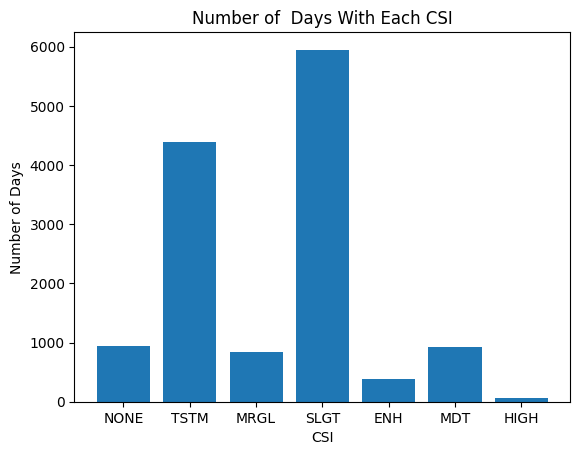

In [6]:
plot_distribution(pph, 'MAX_CAT', category_dict, 'CSI', '', None, show = True)

In [ ]:
def plot_distribution_2d(pph, label_1, label_2, label_1_string, label_2_string, dict_1, dict_2, titlestring, save_location, show=False, defaultbins = 10, step_1 = 1, step_2 = 1):
# plot 2d heatmap for any 2 labels

    data1 = []
    data2 = []

    for i in range(len(pph[label_1])):
        if dict_1 != None:
            data1.append(dict_1[str(pph[label_1].values[i])])
        else: 
            data1.append(pph[label_1].values[i])
        if dict_2 != None:
            data2.append(dict_2[str(pph[label_2].values[i])])
        else:
            data2.append(pph[label_2].values[i])

    
    if dict_1 != None:
        max1 = max(dict_1.values())
        min1 = min(dict_1.values())
        bins1 = np.linspace(min1-.5, max1+.5, 2+max1-min1)
        irange = bins1.size-1

    else:
        if ((max(data1) - min(data1))/step_1).is_integer():
            m = 2
        else: 
            m = 1
            
        if min(data1) < 0:
            bins1 = np.arange(step_1 * round(min(data1)/step_1), max(data1)+m*step_1, step_1)
        else:
            bins1 = np.insert(np.arange(step_1 * round(min(data1)/step_1), max(data1)+m*step_1, step_1), 0, 0)
        
            if isinstance(data1[1], numbers.Integral):
                bins1[1] = bins1[1] + 1
            else:
                bins1[1] = bins1[1] + .00000000001
        num_bins1 = len(bins1)-1
        irange = num_bins1

    if dict_2 != None:
        max2 = max(dict_2.values())
        min2 = min(dict_2.values())
        bins2 = np.linspace(min2-.5, max2+.5, 2+max2-min2)
        jrange = bins2.size-1
    else:
        if ((max(data2) - min(data2))/step_2).is_integer():
            m = 2
        else: 
            m = 1

        if min(data2) < 0:
            bins2 = np.arange(step_2 * round(min(data2)/step_2), max(data2)+m*step_2, step_2)
        else:
            bins2 = np.insert(np.arange(step_2 * round(min(data2)/step_2), max(data2)+m*step_2, step_2), 0, 0)

            if isinstance(data2[1], numbers.Integral):
                bins2[1] = bins2[1] + 1
            else:
                bins2[1] = bins2[1] + .00000000001
        num_bins2 = len(bins2)-1
        jrange = num_bins2

    heatmap = np.histogram2d(data1, data2, bins = (bins1, bins2))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)

    for i in range(irange): 
        for j in range(jrange): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    if dict_1 != None:
        plt.yticks(range(len(list(dict_1.values()))), labels=list(dict_1.keys()))
    else:
        labels = [s + '+' for s in heatmap[1][range(num_bins1)].astype(str)]
        if min(data1) >= 0:
            labels[0] = '0'
            if isinstance(data1[1], numbers.Integral):
                labels[1] = '1+'
            else:
                labels[1] = '0+'
        plt.yticks(range(num_bins1), labels = labels) 
        plt.yticks(fontsize=8)
    if dict_2 != None:
        plt.xticks(range(len(list(dict_2.values()))), labels=list(dict_2.keys()))
    else:
        labels = [s + '+' for s in heatmap[2][range(num_bins2)].astype(str)]
        if min(data2) >= 0:
            labels[0] = '0'
            if isinstance(data2[1], numbers.Integral):
                labels[1] = '1+'
            else:
                labels[1] = '0+'
        plt.xticks(range(num_bins2), labels = labels)
        plt.xticks(fontsize=8)

    plt.ylabel(label_1_string)
    plt.xlabel(label_2_string)

    plt.title("Number of " + titlestring + " Days with each Combination of " + label_1_string + " and " +  label_2_string)
    if save_location != None:
        plt.savefig(save_location + '/' + label_1_string + '_' + label_2_string + '_distribution.png')
    if show:
        plt.show()
    plt.close()

In [ ]:
plot_distribution_2d(pph, 'N_SH_NUM', 'E_SH_NUM', 'North Shift', 'East Shift', None, None, '', None, show = True, step_1 = 100000, step_2 = 100000)

In [7]:
# This makes the next steps work properly for some reason
for k in list(pph.keys()):
    pph[k].values

pph = pph.sel(time=~pph['time'].isin(missing_dates))

# moderate and up days only:
all_pph_dates = pph['time']
mdt_pph_dates = all_pph_dates[pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_pph = pph.sel(time = mdt_pph_dates)
mdt_pph = mdt_pph.sel(time=~mdt_pph['time'].isin(missing_dates))

slgt_pph_dates = all_pph_dates[pph['MAX_CAT'].isin(['SLGT', 'ENH', 'MDT', 'HIGH'])]
slgt_pph = pph.sel(time = slgt_pph_dates)
slgt_pph = slgt_pph.sel(time=~slgt_pph['time'].isin(missing_dates))

# dates since new categorical system 
new_cutoff = '201410230000'
new_pph_dates = all_pph_dates[all_pph_dates >= new_cutoff]
new_pph = pph.sel(time = new_pph_dates)
new_pph = new_pph.sel(time=~new_pph['time'].isin(missing_dates))

# Moderate dates in new system
mdt_new_pph_dates = mdt_pph_dates[mdt_pph_dates >= new_cutoff]
mdt_new_pph = pph.sel(time = mdt_new_pph_dates)
mdt_new_pph = mdt_new_pph.sel(time=~mdt_new_pph['time'].isin(missing_dates))


# dates since day 3 added
day3_cutoff = '200203300000'
day3_pph_dates = all_pph_dates[all_pph_dates >= day3_cutoff]
day3_pph = pph.sel(time = day3_pph_dates)
day3_pph = day3_pph.sel(time=~day3_pph['time'].isin(missing_dates))

# Moderate dates since day 3 added
mdt_day3_pph_dates = mdt_pph_dates[mdt_pph_dates >= day3_cutoff]
mdt_day3_pph = pph.sel(time = mdt_day3_pph_dates)
mdt_day3_pph = mdt_day3_pph.sel(time=~mdt_day3_pph['time'].isin(missing_dates))

slgt_day3_pph_dates = slgt_pph_dates[slgt_pph_dates >= day3_cutoff]
slgt_day3_pph = pph.sel(time = slgt_day3_pph_dates)
slgt_day3_pph = slgt_day3_pph.sel(time=~slgt_day3_pph['time'].isin(missing_dates))


# dates since early day 2 added
day21_cutoff = '199707100000'
day21_pph_dates = all_pph_dates[all_pph_dates >= day21_cutoff]
day21_pph = pph.sel(time = day21_pph_dates)
day21_pph = day21_pph.sel(time=~day21_pph['time'].isin(missing_dates))


# Moderate dates since early day 2 added
mdt_day21_pph_dates = mdt_pph_dates[mdt_pph_dates >= day21_cutoff]
mdt_day21_pph = pph.sel(time = mdt_day21_pph_dates)
mdt_day21_pph = mdt_day21_pph.sel(time=~mdt_day21_pph['time'].isin(missing_dates))


# dates since late day 2 added
day22_cutoff = '199504040000'
day22_pph_dates = all_pph_dates[all_pph_dates >= day22_cutoff]
day22_pph = pph.sel(time = day22_pph_dates)
day22_pph = day22_pph.sel(time=~day22_pph['time'].isin(missing_dates))

# Moderate since late day 2 added
mdt_day22_pph_dates = mdt_pph_dates[mdt_pph_dates >= day22_cutoff]
mdt_day22_pph = pph.sel(time = mdt_day22_pph_dates)
mdt_day22_pph = mdt_day22_pph.sel(time=~mdt_day22_pph['time'].isin(missing_dates))



In [ ]:
def make_plots(pph, label_names, dicts, written_labels, shortstring, titlestring, show=False):
    
    for i in range(len(written_labels)):
        plot_distribution(pph, label_names[i], dicts[i], written_labels[i], titlestring, 'plots/label_distributions/'+ shortstring+'/1d/', show=show)

    for i in range(len(label_names)):
        for j in range(i):
            plot_distribution_2d(pph, label_names[i], label_names[j], written_labels[i], written_labels[j], dicts[i], dicts[j], titlestring, 'plots/label_distributions/'+ shortstring+'/2d/', show=show, step_1 = steps[i], step_2 = steps[j])

In [ ]:
#make_plots(pph, label_names, dicts, written_labels, 'all', 'All')
#make_plots(mdt_pph, label_names, dicts, written_labels, 'mdt', 'Moderate')

#make_plots(new_pph, label_names, dicts, written_labels, 'new', 'New')
#make_plots(mdt_new_pph, label_names, dicts, written_labels, 'mdt_new', 'Moderate New')

#make_plots(day3_pph, label_names, dicts, written_labels, 'day3', 'Since 2002')
make_plots(mdt_day3_pph, label_names, dicts, written_labels, 'mdt_day3', 'Moderate Since 2002')

#make_plots(day21_pph, label_names, dicts, written_labels, 'day21', 'Since 1997')
#make_plots(mdt_day21_pph, label_names, dicts, written_labels, 'mdt_day21', 'Moderate Since 1997')

#make_plots(day22_pph, label_names, dicts, written_labels, 'day22', 'Since 1995')
#make_plots(mdt_day22_pph, label_names, dicts, written_labels, 'mdt_day22', 'Moderate Since 1995')


# Timeseries

Not good for contingency metrics since all days weighted equally

In [ ]:
def plot_timeseries_2(pph, vars_of_interest, var_names, save = True, save_location = 'plots/timeseries', show = True):
    p = pph.sel(time = slice('200203300000', '202312310000'))
    times = pd.to_datetime(p['time'].astype(str), format='%Y%m%d%H%M')

    rolling = 365
    half_rolling_1 = int(np.floor(rolling/2))
    half_rolling_2 = rolling - half_rolling_1 - 1

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(times[half_rolling_1:-half_rolling_2], np.convolve(p[vars_of_interest[0]].data, np.ones(rolling)/rolling, 'valid'))
    ax2.plot(times[half_rolling_1:-half_rolling_2], np.convolve(p[vars_of_interest[1]].data, np.ones(rolling)/rolling, 'valid'), color = 'r')
    ax1.set_ylabel(var_names[0])
    ax2.set_ylabel(var_names[1])
    ax1.set_xlabel('Centered Time')
    plt.title(var_names[0] + ' and ' + var_names[1] + ' 1-Year Running Mean Since 2002')
    fig.legend(var_names)
    fig.tight_layout() 

    if save:
        plt.savefig(save_location + '/timeseries_' + var_names[0] + var_names[1] + '.png')
    if show:
        plt.show()

def plot_timeseries_n(pph, vars_of_interest, var_names, mod_name, ylabel, rolling, colors = None, save = True, save_location = 'plots/timeseries', show = True):
    p = pph.sel(time = slice('200203300000', '202312310000'))
    times = pd.to_datetime(p['time'].astype(str), format='%Y%m%d%H%M')

    half_rolling_1 = np.floor(rolling/2)
    half_rolling_2 = rolling - half_rolling_1 - 1

    for i, var in enumerate(vars_of_interest):
        if colors == None:
            c = None
        else:
            c = colors[i]
        plt.plot(times[int(half_rolling_1[i]):-int(half_rolling_2[i])], np.convolve(p[var].data, np.ones(rolling[i])/rolling[i], 'valid'), c = c)
    
    plt.xlabel('Centered Time')
    plt.ylabel(ylabel)
    plt.title(ylabel + ' 1-Year Running Mean Since 2002')
    plt.legend(var_names)
    plt.tight_layout() 
    
    if save:
        plt.savefig(save_location + '/timeseries_' + mod_name + '.png')

    if show:
        plt.show()



In [ ]:
var_lists_2 = [['POD_NUM', 'FAR_NUM'],
             ['RAMP_UP', 'RAMP_DOWN'],
             ['POD_W_NUM', 'FAR_W_NUM'],
             ['POD_H_NUM', 'FAR_H_NUM'],
             ['POD_T_NUM', 'FAR_T_NUM']]

name_lists_2 = [['Probability of Detection', 'False Alarm Ratio'],
             ['Ramp Up', 'Ramp Down'],
             ['Wind POD', 'Wind FAR'],
             ['Hail POD', 'Hail FAR'],
             ['Tornado POD', 'Tornado FAR']]



for var, names in zip(var_lists_2, name_lists_2):
    plot_timeseries_2(pph, var, names)

In [ ]:
var_lists_n = [['REPORT_NUM', 'WIND_NUM', 'HAIL_NUM', 'TOR_NUM'],
               ['PPH_D_NUM', 'PPH_NUM'],
               ['POD_NUM', 'POD_W_NUM', 'POD_H_NUM', 'POD_T_NUM'],
               ['FAR_NUM', 'FAR_W_NUM', 'FAR_H_NUM', 'FAR_T_NUM'],
               ['DIV_NUM', 'DIV_W_NUM', 'DIV_H_NUM', 'DIV_T_NUM'],
               ['E_SH_NUM', 'E_SH_W_NUM', 'E_SH_H_NUM', 'E_SH_T_NUM'],
               ['N_SH_NUM', 'N_SH_W_NUM', 'N_SH_H_NUM', 'N_SH_T_NUM'],
               ['CSI_NUM', 'CSI_W_NUM', 'CSI_H_NUM', 'CSI_T_NUM'],
               ['FAR_NUM', 'FAR_NUM'],
               ['POD_NUM', 'POD_NUM'],
               ['CSI_NUM', 'CSI_NUM']
]

name_lists_n = [['Total', 'Wind', 'Hail', 'Tornado'],
                ['Dependent Hazards', 'Independent Hazards'],
                ['POD', 'Wind POD', 'Hail POD', 'Tornado POD'],
                ['FAR', 'Wind FAR', 'Hail FAR', 'Tornado FAR'],
                ['Divergence', 'Wind Divergence', 'Hail Divergence', 'Tornado Divergence'],
                ['East Shift', 'Wind East Shift', 'Hail East Shift', 'Tornado East Shift'],
                ['North Shift', 'Wind North Shift', 'Hail North Shift', 'Tornado North Shift'],
                ['CSI', 'Wind CSI', 'Hail CSI', 'Tornado CSI'],
                ['1-year', '3-month'],
                ['1-year', '3-month'],
                ['1-year', '3-month']
]

rolling = [np.array([365, 365, 365, 365]),
           np.array([365, 365]),
           np.array([365, 365, 365, 365]),
           np.array([365, 365, 365, 365]),
           np.array([365, 365, 365, 365]),
           np.array([365, 365, 365, 365]),
           np.array([365, 365, 365, 365]),
           np.array([365, 365, 365, 365]),
           np.array([365, 91]),
           np.array([365, 91]),
           np.array([365, 91])]

hazard_colors = ['black', 'blue', 'green', 'red']
bw_colors = ['black', 'grey']

colors = [hazard_colors, None, hazard_colors, hazard_colors, hazard_colors, hazard_colors, hazard_colors, hazard_colors, bw_colors, bw_colors, bw_colors]

mod_names = ['reports', 'pph', 'hazard_pod', 'hazard_far', 'hazard_div', 'hazard_e_shift', 'hazard_n_shift', 'hazard_csi', 'far', 'pod', 'csi']

axis_names = ['Daily Storm Reports', 'Daily Max PPH', 'Probability of Detection', 'False Alarm Ratio', 'Divergence', 'East Shift (m)', 'North Shift (m)', 'Critical Success Index',  'False Alarm Ratio', 'Probability of Detection', 'Critical Success Index']

for var, names, mod_name, axis_name, r, color in zip(var_lists_n, name_lists_n, mod_names, axis_names, rolling, colors):
    print(var, names, mod_name, axis_name, r, color)
    plot_timeseries_n(pph, var, names, mod_name, axis_name, r, color)

In [ ]:
grid_outlook_location = 'data/outlooks/grid_outlooks.nc'
grid_outlooks = xr.open_dataset(grid_outlook_location)
g = grid_outlooks.sel(time = slice('200203300000', '202312310000'))
times = pd.to_datetime(g['time'].astype(str), format='%Y%m%d%H%M')
rolling = 365
half_rolling_1 = int(np.floor(rolling/2))
half_rolling_2 = rolling - half_rolling_1 - 1

In [ ]:
plt.plot(times[half_rolling_1:-half_rolling_2], np.convolve(g['prob'].sel(outlook = 'Day 1').max(dim=['x', 'y']).data, np.ones(rolling)/rolling, 'valid'))
plt.plot(times[half_rolling_1:-half_rolling_2], np.convolve(g['prob'].sel(outlook = 'Day 2 17').max(dim=['x', 'y']).data, np.ones(rolling)/rolling, 'valid'))
plt.plot(times[half_rolling_1:-half_rolling_2], np.convolve(g['prob'].sel(outlook = 'Day 2 7').max(dim=['x', 'y']).data, np.ones(rolling)/rolling, 'valid'))
plt.plot(times[half_rolling_1:-half_rolling_2], np.convolve(g['prob'].sel(outlook = 'Day 3').max(dim=['x', 'y']).data, np.ones(rolling)/rolling, 'valid'))
plt.legend(['Day 1', 'Day 2 17z', 'Day 2 7z', 'Day 3'])

plt.title('Daily Maximum Any-Hazard Probability Over Time')

plt.ylabel('1-year Running Mean Daily Maximum Any-Hazard Probability')
plt.xlabel('Centered Time')    
plt.savefig('plots/timeseries/prob_over_time.png')


In [ ]:
displacements = xr.load_dataset('data/displacement/displacements.nc')
displacements.sel(time = '201905200000')

In [ ]:
pph.sel(time = '201905200000')

In [ ]:
mdt_day3_pph

# Displacement Histograms

In [ ]:
def stacked_histogram(pph, var_of_interest, var_stack, xlabel, titlestring, legend_title, save_location, bins = 40, show=False, save = True):
    
    plot_arrays = []

    all_var_of_interest = pph[var_of_interest]

    all_var_stack = pph[var_stack]
    stack_values = list(set(all_var_stack.values))

    if 'Northeast' in stack_values:
        stack_values = ['West', 'Great Plains', 'Midwest', 'South', 'Northeast']

    if 'Winter' in stack_values:
        stack_values = ['Winter', 'Spring', 'Summer', 'Fall']

    for stack_value in stack_values:

        plot_arrays.append(all_var_of_interest[all_var_stack == stack_value]/1000)

    cmap = plt.get_cmap('Purples')
    colors = [cmap(.25 + i *.75 / len(plot_arrays)) for i in range(len(plot_arrays))]

    y, _, _ = plt.hist(plot_arrays, bins, stacked=True, label = stack_values, color = colors, range = (-800, 800))
    plt.plot([0, 0], [0, y.max()], color='k', linestyle='-')
    plt.xlabel(xlabel)
    plt.title(titlestring, fontsize = 10)
    plt.legend(title = legend_title)

    if save:
        plt.savefig(save_location)
    if show:
        plt.show()



stacked_histogram(mdt_day3_pph, 'E_SH_W_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Wind Eastward Optical Flow Displacement on MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/wind_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'E_SH_H_NUM', 'SEASON', 'Eastward Displacement (km)', 'Hail Eastward Optical Flow Displacement on MDT+ Days 2002-2023, by Season', 'Season', 'plots/results/hail_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'E_SH_W_NUM', 'SEASON', 'Eastward Displacement (km)', 'Wind Eastward Optical Flow Displacement on MDT+ Days 2002-2023, by Season', 'Season', 'plots/results/wind_displacement_season.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'E_SH_H_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Hail Eastward Optical Flow Displacement on MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/hail_displacement_region.png', show = True, save = True)

stacked_histogram(mdt_day3_pph, 'E_SH_T_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Tornado Eastward Optical Flow Displacement on MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/tor_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'E_SH_NUM', 'REGION_M', 'Eastward Displacement (km)', 'All-Hazard Eastward Optical Flow Displacement on MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/ah_displacement.png', show = True, save = True)

stacked_histogram(slgt_day3_pph, 'E_SH_W_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Wind Eastward Optical Flow Displacement on SLGT+ Days 2002-2023, by Region', 'Region', 'plots/results/slgt_wind_displacement.png', show = True, save = True)
stacked_histogram(slgt_day3_pph, 'E_SH_H_NUM', 'SEASON', 'Eastward Displacement (km)', 'Hail Eastward Optical Flow Displacement on SLGT+ Days 2002-2023, by Season', 'Season', 'plots/results/slgt_hail_displacement.png', show = True, save = True)

stacked_histogram(slgt_day3_pph, 'E_SH_T_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Tornado Eastward Optical Flow Displacement on SLGT+ Days 2002-2023, by Region', 'Region', 'plots/results/slgt_tor_displacement.png', show = True, save = True)
stacked_histogram(slgt_day3_pph, 'E_SH_NUM', 'REGION_M', 'Eastward Displacement (km)', 'All-Hazard Eastward Optical Flow Displacement on SLGT+ Days 2002-2023, by Region', 'Region', 'plots/results/slgt_ah_displacement.png', show = True, save = True)




In [ ]:
stacked_histogram(mdt_day3_pph, 'EW_S_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Eastward Optical Flow Displacement in Western Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/west_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EE_S_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Eastward Optical Flow Displacement in Eastern Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/east_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EW_S_W_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Wind Eastward Optical Flow Displacement in Western Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/wind_west_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EE_S_W_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Wind Eastward Optical Flow Displacement in Eastern Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/wind_east_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EW_S_H_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Hail Eastward Optical Flow Displacement in Western Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/hail_west_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EE_S_H_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Hail Eastward Optical Flow Displacement in Eastern Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/hail_east_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EW_S_T_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Tornado Eastward Optical Flow Displacement in Western Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/tor_west_displacement.png', show = True, save = True)
stacked_histogram(mdt_day3_pph, 'EE_S_T_NUM', 'REGION_M', 'Eastward Displacement (km)', 'Tornado Eastward Optical Flow Displacement in Eastern Halves of MDT+ Days 2002-2023, by Region', 'Region', 'plots/results/colocated/tor_east_displacement.png', show = True, save = True)


## Displacement Rose

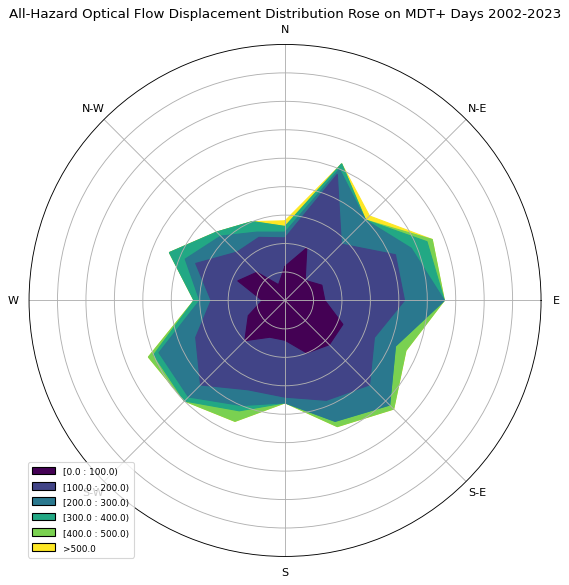

In [43]:
def displacement_rose(pph, hazard, hazard_name, save_location, show=False, save = True):
    
    ax = WindroseAxes.from_ax()

    angles_rad = np.arctan2(pph['N_SH' + hazard + '_NUM'], pph['E_SH' + hazard + '_NUM'])
    angles_deg = np.degrees(angles_rad)
    wd = (90-angles_deg) % 360
    ws = np.sqrt(np.square(pph['N_SH' + hazard + '_NUM']/1000) + np.square(pph['E_SH' + hazard + '_NUM']/1000))

    ax.contourf(wd, ws, bins=np.arange(0, 600, 100))
    ax.set_ylim(0, 45)
    ax.set_yticks(np.arange(0, 45, step=5))
    ax.set_legend()
    ax.set_title(hazard_name + ' Optical Flow Displacement Distribution Rose on MDT+ Days 2002-2023')
    
    if save:
        plt.savefig(save_location)
    if show:
        plt.show()

displacement_rose(mdt_day3_pph, '', 'All-Hazard', 'plots/results/ah_displacement_rose.png', show = True, save = False)

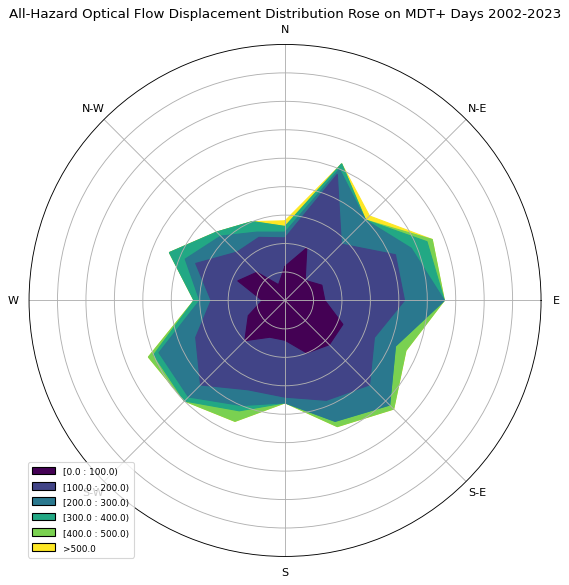

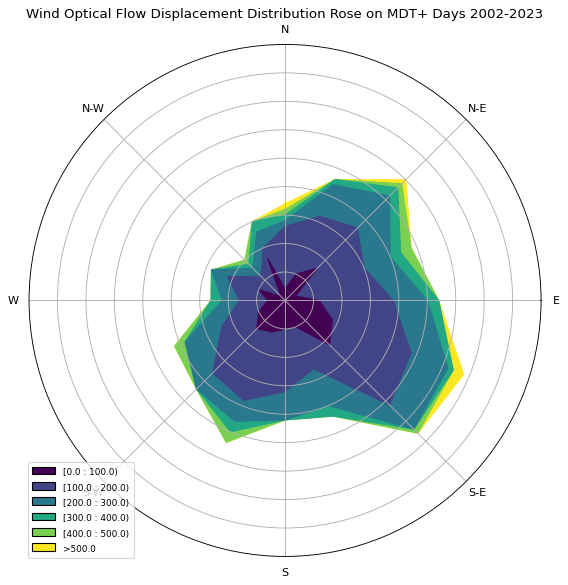

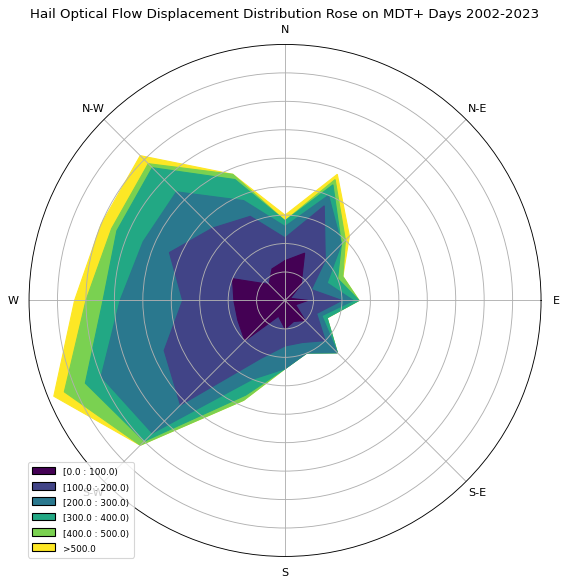

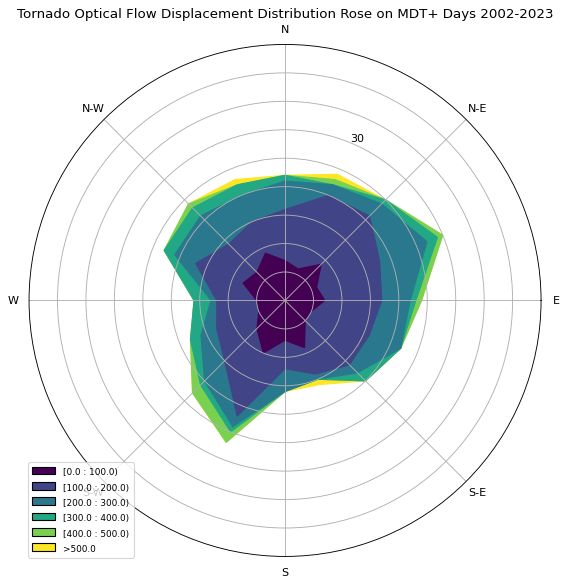

In [44]:
displacement_rose(mdt_day3_pph, '', 'All-Hazard', 'plots/results/ah_displacement_rose.png', show = True, save = True)
displacement_rose(mdt_day3_pph, '_W', 'Wind', 'plots/results/wind_displacement_rose.png', show = True, save = True)
displacement_rose(mdt_day3_pph, '_H', 'Hail', 'plots/results/hail_displacement_rose.png', show = True, save = True)
displacement_rose(mdt_day3_pph, '_T', 'Tornado', 'plots/results/tor_displacement_rose.png', show = True, save = True)

## Plots of Outlook and PPH Distributions

In [ ]:
pph_full_mask = ~pph['time'].isin(missing_dates)
mdt_pph_full_mask = pph_full_mask & pph['time'].isin(mdt_pph_dates)

outlooks_full_mask = (grid_outlooks['time'] > min(pph['time'])) & ~grid_outlooks['time'].isin(missing_dates)
mdt_outlooks_full_mask = outlooks_full_mask & grid_outlooks['time'].isin(mdt_pph_dates)

pph_pre_mask = pph_full_mask & (pph['time'] < new_cutoff)
mdt_pph_pre_mask = pph_pre_mask & pph['time'].isin(mdt_pph_dates)

outlooks_pre_mask = outlooks_full_mask & (grid_outlooks['time'] < new_cutoff)
mdt_outlooks_pre_mask = outlooks_pre_mask & grid_outlooks['time'].isin(mdt_pph_dates)

pph_post_mask = pph_full_mask & ~(pph['time'] < new_cutoff)
mdt_pph_post_mask = pph_post_mask & pph['time'].isin(mdt_pph_dates)

outlooks_post_mask = outlooks_full_mask & ~(grid_outlooks['time'] < new_cutoff)
mdt_outlooks_post_mask = outlooks_post_mask & grid_outlooks['time'].isin(mdt_pph_dates)

In [ ]:
# Density distributions of outlook and PPH probabilities for all days, pre- and post- time split, and for each hazard type

masks = [(pph_full_mask, outlooks_full_mask), (pph_pre_mask, outlooks_pre_mask), (pph_post_mask, outlooks_post_mask)]
pph_var_dict = {' Wind': 'p_perfect_wind',
                ' Hail': 'p_perfect_hail',
                ' Tornado': 'p_perfect_tor',
                '': 'p_perfect_totalsvr'
                }

for hazard in [' Wind', ' Hail', ' Tornado', '']:
    for i, mask in enumerate(masks):
        this_pph = pph.sel(time = mask[0])[pph_var_dict[hazard]]
        this_outlook = grid_outlooks.sel(time = mask[1], outlook = 'Day 1' + hazard)['prob']
        #
        plt.figure(figsize=(8, 6))
        this_outlook_vals = this_outlook.values.flatten()
        bins = np.append((np.unique(this_outlook_vals) - .00001), 1)
        sns.histplot(this_pph.values.flatten()/100, label="PPH", color="blue", bins = bins, stat = 'count')
        sns.histplot(this_outlook_vals, label="Outlook", alpha = .5, color="orange", bins = bins, stat = 'count')
        plt.xlabel("Probability of Hazard Occurance within 25 Miles")
        plt.ylabel("Probability Density")
        plt.yscale('log')
        if hazard == '':
            haz = ' All-Hazard'
        else: 
            haz = hazard
        if i == 0:
            ds = '2002-2023'
        elif i == 1:
            ds = '2002-2014'
        else:
            ds = '2014-2023'
        plt.title("Outlook and PPH distributions for" + haz + " " + ds)
        plt.legend()
        plt.savefig('plots/results/distributions/' + haz.replace(' ', '').replace('-', '') + ds.replace('-', '') + '.png')
        plt.show()
        plt.clf()

In [ ]:
# Density distributions of outlook and PPH probabilities for all days, pre- and post- time split, and for each hazard type

masks = [(mdt_pph_full_mask, mdt_outlooks_full_mask), (mdt_pph_pre_mask, mdt_outlooks_pre_mask), (mdt_pph_post_mask, mdt_outlooks_post_mask)]
pph_var_dict = {' Wind': 'p_perfect_wind',
                ' Hail': 'p_perfect_hail',
                ' Tornado': 'p_perfect_tor',
                '': 'p_perfect_totalsvr'
                }

for hazard in [' Wind', ' Hail', ' Tornado', '']:
    for i, mask in enumerate(masks):
        this_pph = pph.sel(time = mask[0])[pph_var_dict[hazard]]
        this_outlook = grid_outlooks.sel(time = mask[1], outlook = 'Day 1' + hazard)['prob']
        #
        plt.figure(figsize=(8, 6))
        this_outlook_vals = this_outlook.values.flatten()
        bins = np.append((np.unique(this_outlook_vals) - .00001), 1)
        sns.histplot(this_pph.values.flatten()/100, label="PPH", color="blue", bins = bins, stat = 'count')
        sns.histplot(this_outlook_vals, label="Outlook", alpha = .5, color="orange", bins = bins, stat = 'count')
        plt.xlabel("Probability of Hazard Occurance within 25 Miles")
        plt.ylabel("Probability Density")
        plt.yscale('log')
        if hazard == '':
            haz = ' All-Hazard'
        else: 
            haz = hazard
        if i == 0:
            ds = '2002-2023'
        elif i == 1:
            ds = '2002-2014'
        else:
            ds = '2014-2023'
        plt.title("MDT+ Outlook and PPH distributions for" + haz + " " + ds)
        plt.legend()
        plt.savefig('plots/results/distributions/mdt_' + haz.replace(' ', '').replace('-', '') + ds.replace('-', '') + '.png')
        plt.show()
        plt.clf()

In [ ]:
# CDF of outlook and PPH probabilities for all days, pre- and post- time split, and for each hazard type

masks = [(pph_full_mask, outlooks_full_mask), (pph_pre_mask, outlooks_pre_mask), (pph_post_mask, outlooks_post_mask)]
pph_var_dict = {' Wind': 'p_perfect_wind',
                ' Hail': 'p_perfect_hail',
                ' Tornado': 'p_perfect_tor',
                '': 'p_perfect_totalsvr'
                }

for hazard in [' Wind', ' Hail', ' Tornado', '']:
    for i, mask in enumerate(masks):
        this_pph = pph.sel(time = mask[0])[pph_var_dict[hazard]]
        this_outlook = grid_outlooks.sel(time = mask[1], outlook = 'Day 1' + hazard)['prob']
        #
        plt.figure(figsize=(8, 6))
        this_outlook_vals = this_outlook.values.flatten()

        counts, bin_edges = np.histogram(this_pph.values.flatten()/100, bins=1000, density=True)
        ccdf = 1 - np.cumsum(counts * np.diff(bin_edges))  # Cumulative sum to compute the CDF
        plt.plot(bin_edges[1:], ccdf, label="PPH", color="blue")

        counts, bin_edges = np.histogram(this_outlook_vals, bins=100, density=True)
        ccdf = 1 - np.cumsum(counts * np.diff(bin_edges))  # Cumulative sum to compute the CDF
        plt.plot(bin_edges[1:], ccdf, label="Outlook", color="orange")

        #sns.kdeplot(this_pph.values.flatten()/100, cumulative = True, label="PPH", color="blue")
        #sns.kdeplot(this_outlook_vals, cumulative = True, label="Outlook", color="orange")
        plt.xlabel("Probability of Hazard Occurance within 25 Miles")
        plt.ylabel("1 - Cumulative Probability")
        plt.yscale('log')
        if hazard == '':
            haz = ' All-Hazard'
        else: 
            haz = hazard
        if i == 0:
            ds = '2002-2023'
        elif i == 1:
            ds = '2002-2014'
        else:
            ds = '2014-2023'
        plt.title("Outlook and PPH Complimentary CDFs for" + haz + " " + ds)
        plt.legend()
        plt.savefig('plots/results/cdfs/' + haz.replace(' ', '').replace('-', '') + ds.replace('-', '') + '.png')
        plt.show()
        plt.clf()

In [ ]:
# CDF of outlook and PPH probabilities for MDT days, pre- and post- time split, and for each hazard type

masks = [(mdt_pph_full_mask, mdt_outlooks_full_mask), (mdt_pph_pre_mask, mdt_outlooks_pre_mask), (mdt_pph_post_mask, mdt_outlooks_post_mask)]
pph_var_dict = {' Wind': 'p_perfect_wind',
                ' Hail': 'p_perfect_hail',
                ' Tornado': 'p_perfect_tor',
                '': 'p_perfect_totalsvr'
                }

for hazard in [' Wind', ' Hail', ' Tornado', '']:
    for i, mask in enumerate(masks):
        this_pph = pph.sel(time = mask[0])[pph_var_dict[hazard]]
        this_outlook = grid_outlooks.sel(time = mask[1], outlook = 'Day 1' + hazard)['prob']
        #
        plt.figure(figsize=(8, 6))
        this_outlook_vals = this_outlook.values.flatten()

        counts, bin_edges = np.histogram(this_pph.values.flatten()/100, bins=1000, density=True)
        ccdf = 1 - np.cumsum(counts * np.diff(bin_edges))  # Cumulative sum to compute the CDF
        plt.plot(bin_edges[1:], ccdf, label="PPH", color="blue")

        counts, bin_edges = np.histogram(this_outlook_vals, bins=100, density=True)
        ccdf = 1 - np.cumsum(counts * np.diff(bin_edges))  # Cumulative sum to compute the CDF
        plt.plot(bin_edges[1:], ccdf, label="Outlook", color="orange")

        #sns.kdeplot(this_pph.values.flatten()/100, cumulative = True, label="PPH", color="blue")
        #sns.kdeplot(this_outlook_vals, cumulative = True, label="Outlook", color="orange")
        plt.xlabel("Probability of Hazard Occurance within 25 Miles")
        plt.ylabel("1 - Cumulative Probability")
        plt.yscale('log')
        if hazard == '':
            haz = ' All-Hazard'
        else: 
            haz = hazard
        if i == 0:
            ds = '2002-2023'
        elif i == 1:
            ds = '2002-2014'
        else:
            ds = '2014-2023'
        plt.title("Outlook and PPH Complimentary CDFs for" + haz + " " + ds)
        plt.legend()
        plt.savefig('plots/results/cdfs/mdt_' + haz.replace(' ', '').replace('-', '') + ds.replace('-', '') + '.png')
        plt.show()
        plt.clf()

# Identifying Days with Missing Data

In [ ]:
grid_outlook_location = 'data/outlooks/grid_outlooks.nc'
grid_outlooks = xr.open_dataset(grid_outlook_location)

In [ ]:
max_outlooks = grid_outlooks.max(dim = ['x', 'y'])['prob']

In [ ]:
pph['MAX_CAT'][-300:-150]

In [ ]:
dates = max_outlooks['time']
thresholds = {'': .3,
              ' Tornado': .3,
              ' Wind': .5,
              ' Hail': .5}
days = ['Day 3', 'Day 2 7', 'Day 2 17', 'Day 1']
hazard_days = ['Day 2 7', 'Day 2 17', 'Day 1']
investigate_dates = []
for date in dates:
    max_outlooks_date = max_outlooks.sel(time = date)
    for hazard in ['', ' Tornado', ' Wind', ' Hail']:
        if hazard == '':
            this_days = days
        else:
            this_days = hazard_days
        outlook_keys = [item + hazard for item in this_days]
        max_prob = max_outlooks_date.sel(outlook = outlook_keys).max()
        if max_prob >= thresholds[hazard]:
            for outlook_key in outlook_keys:
                if max_outlooks_date.sel(outlook = outlook_key) == 0 and outlook_key == 'Day 1':
                    print(str(date.data) + ' ' + str(outlook_key))
                    investigate_dates.append(str(date.data))

                

print(investigate_dates)

In [ ]:
str(date.data)

# OLD NON-GENERALIZED PLOTTING OF RAMPS / SCRATCH WORK

Investigate: old ramp ups by 5? Why lots of 5 and not 4? And none region, make sure no PPH.

In [ ]:
#test = outlooks[outlooks['REGION'] != 'NONE']
#test[test['DATE'] <= '199203160000']

In [ ]:
#test_outlooks = outlooks[outlooks['MAX_CAT'] == 'SLGT']
#test_outlooks = test_outlooks[test_outlooks['RAMP_UP'] == 3]
#set(test_outlooks['DATE'])

In [ ]:
#outlooks[outlooks['DATE'] == '200208030000']

In [ ]:
#plot_day('201010100000', outlooks, pph, reports)

In [ ]:
def plot_ramps(pph, title_insert=''):
    # 2d histogram of ramps
    # NOT FOR USE
    ramp_up_bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    ramp_up_amounts = [0, 1, 2, 3, 4, 5, 6]
    ramp_down_amounts = [-6, -5, -4, -3, -2, -1, 0]
    ramp_down_bins = [-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -.5, .5]
    heatmap = np.histogram2d(np.array(pph['RAMP_UP'][pph['RAMP_UP']!= 'NONE'], dtype=int), np.array(pph['RAMP_DOWN'][pph['RAMP_UP']!= 'NONE'], dtype=int), bins = (ramp_up_bins, ramp_down_bins))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)
    bins = len(ramp_up_bins)
    for i in range(bins-1): 
        for j in range(bins-1): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    plt.xticks(ramp_up_amounts, labels=ramp_down_amounts)
    plt.yticks(ramp_up_amounts, labels=ramp_up_amounts)
    plt.xlabel("Ramp Down")
    plt.ylabel("Ramp Up")
    plt.title("Number of " + title_insert + "Days with each Ramp Up and Ramp Down Amount")
    plt.show()

In [ ]:
str(mdt_pph['time'].values).replace('\n ', ' ').replace(' ', ', ')

In [ ]:
mdt_new_pph['time'].where(mdt_new_pph['MAX_CAT'] == 'HIGH')
